# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-500']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Counting objects: 100% (322/322), done.
remote: Compressing objects: 100% (269/269), done.
remote: Total 36449 (delta 160), reused 53 (delta 53), pack-reused 36127 (from 4)
Receiving objects: 100% (36449/36449), 22.26 MiB | 25.84 MiB/s, done.
Resolving deltas: 100% (26249/26249), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # actual architecture below is scaled to match n: [0.5, 0.25, 1024]

backbone:
  - [-1, 1, TorchVision, [1280, efficientnet_b0, DEFAULT, True, 2, True]] # 0

head:
  # Extract features from EfficientNet
  - [0, 1, Index, [40, 4]]            # 1: P3 raw (stride 8)
  - [0, 1, Index, [112, 6]]           # 2: P4 raw (stride 16)
  - [0, 1, Index, [320, 8]]           # 3: P5 raw (stride 32)

  # Project to scaled YOLOv11 base channels
  - [1, 1, Conv, [64, 1, 1]]          # 256 × 0.25 → 64
  - [2, 1, Conv, [128, 1, 1]]         # 512 × 0.25 → 128
  - [3, 1, Conv, [256, 1, 1]]         # 1024 × 0.25 → 256

  # FPN: P5 → P4
  - [6, 1, nn.Upsample, [None, 2, "nearest"]]   # 7: upsample P5
  - [[7, 5], 1, Concat, [1]]                    # 8: P5 + P4
  - [-1, 1, C3k2, [128, False]]                 # 9: scaled down (512 → 128, 2 → 1)

  # FPN: P4 → P3
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]   # 10: upsample P4
  - [[10, 4], 1, Concat, [1]]                   # 11: + P3
  - [-1, 1, C3k2, [64, False]]                  # 12: 256 → 64

  # PAN: P3 → P4
  - [12, 1, Conv, [64, 3, 2]]                   # 256 → 64
  - [[13, 9], 1, Concat, [1]]                   # 14
  - [-1, 1, C3k2, [128, False]]                 # 15

  # PAN: P4 → P5
  - [15, 1, Conv, [128, 3, 2]]                  # 512 → 128
  - [[16, 6], 1, Concat, [1]]                   # 17
  - [-1, 1, C3k2, [256, True]]                  # 18: 1024 → 256

  # Final detection layers
  - [[12, 15, 18], 1, Detect, [nc]]             # 19
  

  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 32, 320, 320])
# 2 torch.Size([1, 16, 320, 320])
# 3 torch.Size([1, 24, 160, 160])
# 4 torch.Size([1, 40, 80, 80])
# 5 torch.Size([1, 80, 40, 40])
# 6 torch.Size([1, 112, 40, 40])
# 7 torch.Size([1, 192, 20, 20])
# 8 torch.Size([1, 320, 20, 20])
# 9 torch.Size([1, 1280, 20, 20])
""")


model = YOLO(model_file, task="detect")

WARNING ⚠️ no model scale passed. Assuming scale='n'.


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 145MB/s]


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train
val: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val
test: /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=15,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.105 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=15, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 16.2MB/s]


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1   4007548  ultralytics.nn.modules.block.TorchVision     ['efficientnet_b0', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [4]                           
  2                   0  1         0  ultralytics.nn.modules.conv.Index            [6]                           
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [8]                           
  4                   1  1      2688  ultralytics.nn.modules.conv.Conv             [40, 64, 1, 1]                
  5                   2  1     14592  ultralytics.nn.modules.conv.Conv             [112, 128, 1, 1]              
  6                   3  1     82432  ultralytics.nn.modules.conv.Conv             [320, 256, 

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/train... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:02<00:00, 200.36it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/train/9569.jpg: 1 duplicate labels removed
train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:01<00:00, 182.95it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.


WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 93 weight(decay=0.0), 132 weight(decay=0.0005), 131 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      7.15G       3.57      90.27      2.861         38        640: 100%|██████████| 32/32 [00:16<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300      8.87G       4.22      35.26      3.117         45        640: 100%|██████████| 32/32 [00:15<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.77it/s]

                   all        200       1017          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      8.89G      4.045      5.946      2.033         41        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.61it/s]

                   all        200       1017        0.2      0.052     0.0315     0.0058



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      8.89G      3.575      3.527      1.445         36        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.232       0.19     0.0832     0.0172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      8.89G      3.281      3.039      1.307         28        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]

                   all        200       1017      0.294      0.253      0.148     0.0332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      8.89G       3.21      2.611      1.244         17        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.05it/s]

                   all        200       1017      0.343      0.296      0.182     0.0427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      8.89G      3.055      2.342      1.227         47        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        200       1017      0.355      0.313      0.218     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      8.89G      2.954      2.201      1.191          7        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.363      0.317       0.21     0.0469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      8.89G      2.878      1.956      1.183         51        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.13it/s]

                   all        200       1017      0.433      0.362      0.271     0.0753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300      8.89G      2.919      1.983      1.141         42        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017      0.487      0.354      0.283     0.0745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      8.89G      2.885      1.887      1.094         68        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.60it/s]

                   all        200       1017       0.49      0.376      0.316     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      8.89G      2.856       1.85      1.153         30        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.94it/s]

                   all        200       1017      0.451      0.373      0.291     0.0743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      8.89G       2.83      1.788      1.126         15        640: 100%|██████████| 32/32 [00:15<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200       1017      0.432      0.367      0.293     0.0713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      8.89G      2.825      1.758      1.121         22        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200       1017      0.484      0.369      0.308     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      8.89G      2.744      1.701      1.102         14        640: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200       1017      0.478      0.404      0.332     0.0956



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      8.89G      2.666       1.66      1.164         31        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]

                   all        200       1017      0.498      0.386      0.338     0.0925



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      8.89G      2.714      1.548      1.108         27        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.08it/s]

                   all        200       1017      0.524      0.397       0.35     0.0989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      8.89G      2.638      1.581      1.119         46        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

                   all        200       1017      0.533       0.38      0.348      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300      8.89G      2.562      1.497      1.076         28        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1017       0.49      0.409       0.35     0.0995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300      8.89G       2.62      1.508      1.084         21        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200       1017      0.473      0.399      0.345     0.0972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      8.89G      2.597      1.455      1.098         35        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

                   all        200       1017      0.513      0.387      0.355      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      8.89G      2.611      1.438      1.097         29        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.14it/s]

                   all        200       1017      0.521      0.399      0.362      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      8.89G      2.571      1.453      1.103         39        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1017      0.524      0.391      0.358      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300      8.89G      2.544       1.38      1.074         35        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        200       1017      0.513      0.441      0.375      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      8.89G      2.484      1.341      1.086         35        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.90it/s]

                   all        200       1017      0.544      0.412      0.387      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      8.89G       2.56      1.383      1.099         47        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200       1017      0.556      0.421      0.393      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      8.89G      2.511      1.307      1.024         15        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.99it/s]

                   all        200       1017      0.608      0.447      0.412      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      8.89G      2.524      1.298      1.058         43        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017      0.577      0.432      0.387       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      8.89G      2.499      1.346       1.09         30        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        200       1017      0.569      0.402      0.396      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      8.89G      2.485       1.25      1.076         32        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]

                   all        200       1017      0.551      0.426      0.389      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      8.89G      2.479      1.312      1.065         24        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.83it/s]

                   all        200       1017      0.575        0.4      0.366      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300      8.89G      2.547      1.316      1.056         47        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        200       1017      0.558      0.411      0.398      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      8.89G       2.53      1.281      1.053         31        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.36it/s]

                   all        200       1017       0.55      0.436      0.417       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      8.89G       2.49      1.227      1.064         35        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017      0.559       0.44      0.415       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      8.89G      2.515      1.237      1.035         27        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1017      0.535      0.406      0.372      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      8.89G      2.345      1.194      1.067         51        640: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.597       0.43      0.454      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      8.89G      2.424      1.201      1.041         32        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017       0.61       0.44      0.446      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300      8.89G      2.383      1.153      1.028         47        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.53it/s]

                   all        200       1017      0.556      0.394      0.393      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      8.89G       2.38      1.157      1.021         23        640: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

                   all        200       1017      0.594      0.425      0.421      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      8.89G      2.405      1.188      1.064         18        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

                   all        200       1017      0.572      0.447      0.423      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      8.89G      2.431        1.2      1.041         24        640: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]

                   all        200       1017      0.566      0.382      0.364      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      8.89G      2.553      1.259       1.08         23        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]

                   all        200       1017      0.601      0.423       0.44      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      8.89G      2.322      1.108      1.003         36        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]

                   all        200       1017       0.59      0.449      0.456      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      8.89G      2.288       1.08      1.044         20        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.31it/s]

                   all        200       1017      0.579      0.453      0.452      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      8.89G      2.322       1.08      1.034         54        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.25it/s]

                   all        200       1017       0.59      0.397      0.408      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      8.89G      2.248       1.08      1.038         32        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.32it/s]

                   all        200       1017      0.627      0.443       0.45      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      8.89G      2.308      1.094      1.043         38        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

                   all        200       1017      0.603      0.452      0.454      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      8.89G      2.247      1.109       1.05         14        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

                   all        200       1017      0.645      0.455      0.477      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      8.89G      2.268      1.094      1.005         30        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

                   all        200       1017      0.611      0.443       0.46      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      8.89G      2.378      1.102      1.017         12        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.04it/s]

                   all        200       1017      0.558      0.459      0.455       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      8.89G      2.356      1.118      1.062         24        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]


                   all        200       1017      0.592      0.467      0.458       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      8.89G      2.234      1.072      1.036         31        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

                   all        200       1017      0.607      0.458      0.458      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      8.89G      2.303      1.077      1.023         62        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.19it/s]

                   all        200       1017      0.641       0.45      0.459      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300      8.89G       2.22      1.061      1.031         31        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]

                   all        200       1017      0.613      0.487      0.476      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      8.89G      2.232      1.031      1.018         39        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]

                   all        200       1017      0.628      0.465       0.49      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      8.89G      2.173      1.001     0.9972         12        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.17it/s]

                   all        200       1017      0.594      0.464      0.465      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      8.89G      2.219     0.9885      1.019         52        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1017      0.634      0.434      0.458      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      8.89G      2.229      1.038      1.007         21        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

                   all        200       1017      0.605      0.423      0.437      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300      8.89G       2.23      1.033      1.012         34        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        200       1017      0.612      0.405      0.433      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      8.89G      2.273      1.046      1.006         28        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1017      0.642      0.482      0.475      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      8.89G       2.18      1.006      1.003         16        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

                   all        200       1017      0.612      0.478      0.475       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      8.89G      2.211      1.019      1.017         31        640: 100%|██████████| 32/32 [00:15<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        200       1017      0.592      0.466      0.473      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      8.89G      2.184      1.014     0.9882         22        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        200       1017      0.609      0.467      0.464      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      8.89G      2.163     0.9947       1.02         27        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.96it/s]

                   all        200       1017      0.672      0.479      0.481      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      8.89G      2.196     0.9839       1.01         37        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.18it/s]

                   all        200       1017       0.62       0.46      0.462      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300      8.89G      2.158      1.011      1.012         13        640: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.26it/s]

                   all        200       1017      0.627      0.474      0.488      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      8.89G      2.229      0.996      1.003         62        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.09it/s]

                   all        200       1017      0.651       0.48      0.494      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300      8.89G      2.166     0.9789     0.9899         21        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.24it/s]

                   all        200       1017      0.614      0.486      0.478      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      8.89G      2.185     0.9711     0.9851         50        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        200       1017      0.634      0.477      0.481      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      8.89G      2.147     0.9708       1.01         20        640: 100%|██████████| 32/32 [00:15<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.40it/s]

                   all        200       1017      0.597      0.485      0.471      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      8.89G      2.173     0.9896      1.006         26        640: 100%|██████████| 32/32 [00:14<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.35it/s]

                   all        200       1017      0.631      0.459       0.46       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      8.89G      2.109     0.9517     0.9892         35        640: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]

                   all        200       1017      0.673      0.467      0.501       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      8.89G      2.091     0.9659     0.9926         25        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.07it/s]

                   all        200       1017      0.644       0.44      0.466      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      8.89G       2.09     0.9249     0.9823         38        640: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

                   all        200       1017      0.583      0.432      0.449      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      8.89G      2.081     0.9627     0.9788         39        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.22it/s]

                   all        200       1017      0.614      0.448      0.466      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      8.89G      2.051     0.9296     0.9635         21        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.46it/s]

                   all        200       1017      0.647      0.489      0.499      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      8.89G       2.06     0.9406     0.9815         25        640: 100%|██████████| 32/32 [00:14<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]

                   all        200       1017       0.62      0.472      0.478      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      8.89G      2.049       0.95       1.02         32        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]

                   all        200       1017       0.66      0.447      0.463      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      8.89G      2.075     0.9324     0.9955         35        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

                   all        200       1017      0.647      0.451       0.49      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300      8.89G      2.138     0.9513     0.9829         44        640: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]

                   all        200       1017       0.67      0.496      0.504      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      8.89G      2.057     0.9173     0.9805         40        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.30it/s]

                   all        200       1017      0.649      0.483      0.492      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      8.89G      2.088     0.9619      1.002         23        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.37it/s]

                   all        200       1017      0.638      0.447      0.466      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      8.89G      2.082     0.9269     0.9941         30        640: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.39it/s]

                   all        200       1017      0.622      0.472      0.479      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      8.89G      2.091     0.9342     0.9846         46        640: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  3.82it/s]

                   all        200       1017      0.625      0.478      0.484      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      8.89G      2.078       0.93      0.998         45        640: 100%|██████████| 32/32 [00:14<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.43it/s]

                   all        200       1017      0.612      0.473       0.47       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      8.89G      2.108     0.9692      1.027         32        640: 100%|██████████| 32/32 [00:15<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

                   all        200       1017      0.627      0.494      0.501      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      8.89G      2.072     0.9417     0.9838         31        640: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]

                   all        200       1017      0.631      0.481      0.485      0.174
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 72, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



87 epochs completed in 0.429 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 11.1MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 11.1MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 288 layers, 5,323,775 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]


                   all        200       1017      0.672      0.467        0.5       0.18


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.3ms preprocess, 4.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dafb93475e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
!zip -r yolo11_efficientnet.zip /kaggle/working/model

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg: 384x640 6 humans, 15.7ms
Speed: 2.4ms preprocess, 15.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


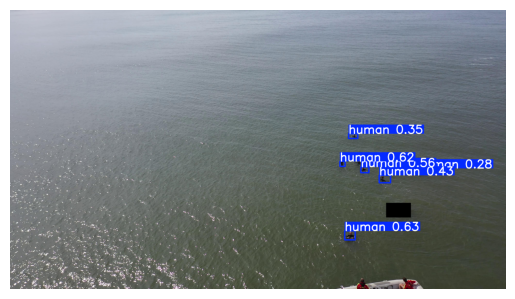

Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 288 layers, 5,323,775 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels/test... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 846.00it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:05<00:00,  2.49it/s]


                   all        200       1072       0.69      0.557      0.563      0.209


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.2ms preprocess, 4.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val3
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dafe8ec85e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.0

In [8]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-500/seaDronesSee_yolo/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

metrics = model.val(
    data=data_file,
    split="test"
)

print(metrics)